## About this project

Credit card fraud can be defined as any fraud or theft that involves a credit card. Credit card fraud aims to purchase goods or steal money with someone else credit account. Advance in modern-day technology has created more room for credit card fraud. Since the invention of online purchases, perpetrators no longer need a physical card to make an unauthorized purchase. Additionally, electronic databases containing credit card data can get hacked or crash on their own, releasing customers' credit card information. These electronic database hacks put the security of many accounts at risk at once.

Common forms of credit card fraud include:

- Lost or stolen cards are used without their owner's permission.

- Credit cards are 'skimmed,' where the card is cloned or copied using a special swipe machine to create a duplicate.

- Card details, such as the card number, cardholder name, date of birth, and address, are stolen from online databases or through email scams. These stolen details are then sold and utilized for fraud on the internet or over the phone. This type of fraud is often referred to as 'card-not-present' fraud.

- Fraudulent applications are made in someone else's name for a new credit card, without the person's knowledge or consent.



The goal of this project is to build a fraud detection system using machine learning. This system will have the ability to classify an online credit card transaction as fraudulent or not fraudulent based on the transaction details. The machine learning model will learn from past credit card transaction data and use the patterns it learns from the data to identify if a new transaction is fraudulent or not. Furthermore, the model will be hosted as a web service that accepts credit card transaction details in a JSON data format and returns a prediction of whether the transaction is fraudulent or not. Deploying this model as a web service will be beneficial to financial institutions, banks, or online stores as they can easily feed transaction details to the machine learning system and the model will return its prediction. This can help dectecting in potential fraud in trade and therefore get the transaction flagged and declined. By identifying potential instances of fraud, companies can take steps to prevent fraudulent activity from occurring, which can save them a significant amount of money loss.

### About the dataset

The dataset used to in this machine learning project was gotten from [kaggle](https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud). 
#### Data columns/features explained
The data contains 8 features and 1000000 observations. Below is an explanation of the features.

- distance_from_home - the distance from home where the transaction happened.
- distance_from_last_transaction - the distance from last transaction happened.
- ratio_to_median_purchase_price - Ratio of purchased price transaction to median purchase price.
- repeat_retailer - Is the transaction happened from same retailer.
- used_chip - Is the transaction through chip (credit card).
- used_pin_number - Is the transaction happened by using PIN number.
- online_order - Is the transaction an online order.
- fraud(target) - Is the transaction fraudulent.

### Challenges in credit card fraud detection
- It's not always easy to agree on the ground truth for what "fraud" means.
- Most of the transactions are tagged as not fraudulent, therefore leading to a class imbalance of the dataset
- Fraud detection dataset contains sensitive pieces of information, therefore a lot of data representations a usually hidden


### Import libraries and load data 

In [45]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import imblearn
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [2]:
data=pd.read_csv("/Users/victoroshimua/Downloads/card_transdata.csv")

In [3]:
data.head().T

,0,1,2,3,4
distance_from_home,57.877857,10.829943,5.091079,2.247564,44.190936
distance_from_last_transaction,0.311140,0.175592,0.805153,5.600044,0.566486
ratio_to_median_purchase_price,1.945940,1.294219,0.427715,0.362663,2.222767
repeat_retailer,1.000000,1.000000,1.000000,1.000000,1.000000
used_chip,1.000000,0.000000,0.000000,1.000000,1.000000
used_pin_number,0.000000,0.000000,0.000000,0.000000,0.000000
online_order,0.000000,0.000000,1.000000,1.000000,1.000000
fraud,0.000000,0.000000,0.000000,0.000000,0.000000


### EDA

In [4]:
data.shape

(1000000, 8)

In [20]:
col=data.columns
list(col)

['distance_from_home',
 'distance_from_last_transaction',
 'ratio_to_median_purchase_price',
 'repeat_retailer',
 'used_chip',
 'used_pin_number',
 'online_order',
 'fraud']

In [5]:
data.describe()
## checking for nans, sometimes nans are stored as large numbers (99999999)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
## Check for missing data
data.isnull().any()


distance_from_home                False
distance_from_last_transaction    False
ratio_to_median_purchase_price    False
repeat_retailer                   False
used_chip                         False
used_pin_number                   False
online_order                      False
fraud                             False
dtype: bool

##### Observation: No missing data

In [7]:
## Exploring the target "Fraud"
data["fraud"].value_counts(normalize=True).round(2)

0.0    0.91
1.0    0.09
Name: fraud, dtype: float64

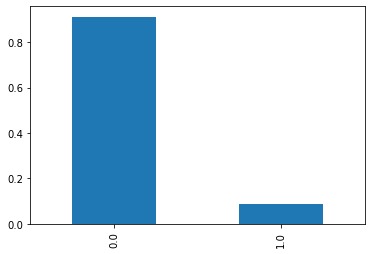

In [8]:
data["fraud"].value_counts(normalize=True).plot(kind="bar")
plt.show()

#### Observation: Fraud (1) is about 10% of the class and not Fraud (0) is 90% of the class, this is a problem of class imbalance 

## Setting up validation framework
#### The data set will be splitted into train(60%), validation(20%), test(20%) sets 

In [9]:
data_full_train,data_test=train_test_split(data,test_size=0.2,random_state=1)
data_train,data_val=train_test_split(data_full_train,test_size=0.25,random_state=1)

In [10]:
len(data_train),len(data_test),len(data_val)

(600000, 200000, 200000)

In [11]:
y_train=data_train.fraud
y_test=data_test.fraud
y_val=data_val.fraud

##### Since the dataset has class imbalance, i will apply SMOTE(Synthetic Minority Oversampling Technique) to the trainset

In [12]:
# Apply SMOTE on the training data
smote = SMOTE(random_state=1)
data_train_oversampled, y_train_oversampled = smote.fit_resample(data_train, y_train)


In [13]:
del data_train_oversampled['fraud']
del data_test['fraud']
del data_val['fraud']


In [15]:
y_train_oversampled.value_counts(normalize=True)

0.0    0.5
1.0    0.5
Name: fraud, dtype: float64

<AxesSubplot:>

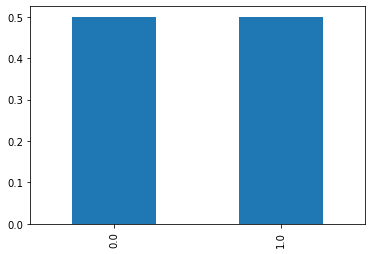

In [16]:
y_train_oversampled.value_counts(normalize=True).plot(kind="bar")

### Observation: After using smote technique to solve class imbalance problem on the training set, the target(fraud) has become balanced

## Features Importance (Correlation)

In [27]:
data_full_train.corrwith(data_full_train.fraud).to_frame('correlation')

,correlation
distance_from_home,0.185024
distance_from_last_transaction,0.088343
ratio_to_median_purchase_price,0.463126
repeat_retailer,-0.000997
used_chip,-0.060728
used_pin_number,-0.100202
online_order,0.192077
fraud,1.000000


### Observations

- distance_from_home: Positive correlation (0.185024) with the fraud column, indicating a weak positive relationship.

- distance_from_last_transaction: Positive correlation (0.088343) with the fraud column, indicating a weak positive relationship.

- ratio_to_median_purchase_price: Positive correlation (0.463126) with the fraud column, indicating a moderate positive relationship.

- repeat_retailer: Almost no correlation (-0.000997) with the fraud column, suggesting no significant relationship.

- used_chip: Negative correlation (-0.060728) with the fraud column, indicating a weak negative relationship.

- used_pin_number: Negative correlation (-0.100202) with the fraud column, indicating a weak negative relationship.

- online_order: Positive correlation (0.192077) with the fraud column, indicating a weak positive relationship.

- fraud: The correlation of 1.000000 represents the correlation of the fraud column with itself, which is always perfect.


## Modeling
To build a machine learing model i will use XGboost model right away since XGoost perform well for tabular data

In [39]:
dtrain=xgb.DMatrix(data_train_oversampled, label= y_train_oversampled)
dval=xgb.DMatrix(data_val,label=y_val)
xgb_params={
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)


## Evaluating model performance
I will use two different evaluation metrics
- Roc_Auc (Receiver Operating Characteristic Area Under the Curve)
- Confusion table

In [52]:
prediction = model.predict(dval)
roc_auc_score(y_val, prediction)

0.9999999623312275

#### Observation:  The ROC AUC score is 0.9999999623312275, this indicates excellent performance, suggesting that the model is highly effective in distinguishing between fraud and not fraud instances in the binary classification task.

In [54]:
prediction_binary = (prediction >= 0.5).astype(int)
confusion_matrix(y_val, prediction_binary)


array([[182547,      2],
       [     2,  17449]])

### Observation: 
- True Positives (TP):  182,547 instances correctly predicted as Fraud.
- False Positives (FP):  2 instances wrongly predicted as Fraud.
- False Negatives (FN):  2 instances wrongly predicted as Not fraud.
- True Negatives (TN): 17,449 instances correctly predicted as Not fraud.
